 # Optimizers for Neural Networks
 In this notebook, we will discuss the most popular optimizers used in training neural networks. You will implement optimizers from simple to compex:
    - Stochastic Gradient Descent (SGD)
    - SGD with Momentum
    - RMSprop
    - Adam

> ## Learning Objectives
> - Understand what optimizers are and why they are used
> - Get an intuition for momentum and RMS
> - Underatand what the differnet hyperparameters in Adam are and how they affect the training process


In [1]:
from typing import Iterable, Union, Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.figure
import torch as t
import torch.nn.functional as F
from einops import rearrange, repeat
import torch
from tqdm.auto import tqdm
import numpy as np

from SGD_tests import test_SGD, test_momentum, test_RMSprop, test_Adam, plot_rosenbrock

c:\Users\wusch\working_directory\ML4good\git_folder\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The job of an optimizer is to find the minimum in a Loss funciton. The loss function, we are going to consider here is Rosenbrocks Banana function. 
Of cause, in practice, loss funcitons are verry high dimensional and not so simple. But we have an easier time plotting 2D functions.

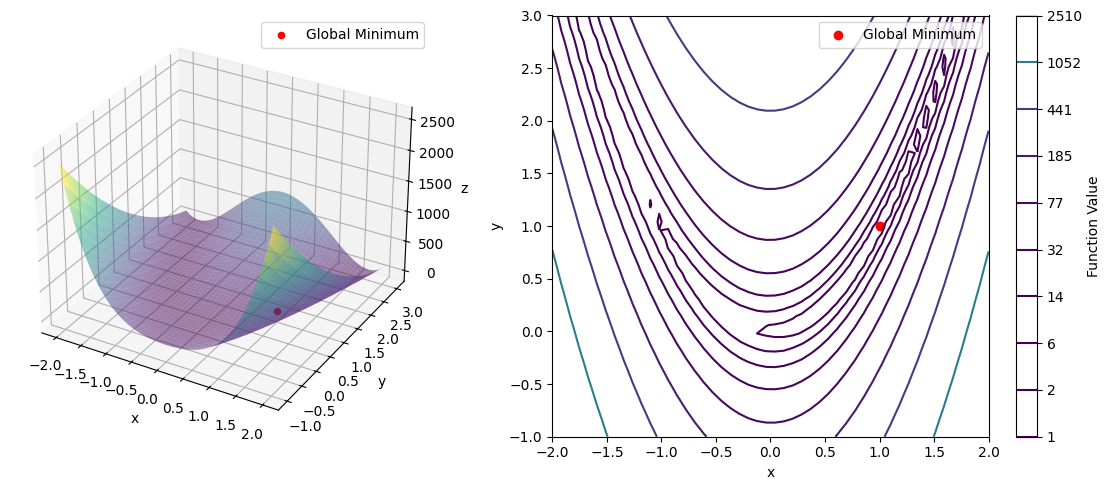

In [2]:

def rosenbrocks_banana(x: t.Tensor, y: t.Tensor, a=1, b=100) -> t.Tensor:
    return (a - x) ** 2 + b * (y - x**2) ** 2 + 1

trajectories = {}
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement the training loop and Stochastic Gradient Descent (SGD) optimizer
(2-5 mins)

The training loop consists of the following steps:
 - Compute the loss
- Compute the gradients
- Update the parameters
- zero the gradients

The update rule for Stochastic Gradient Descent (SGD) is given by:

$$\theta_{t+1} = \theta_t - \alpha \cdot \nabla_\theta \text{Loss}(\theta_t)$$

where:
- $\theta_t$ represents the model's parameters at iteration $t$.
- $\alpha$ is the learning rate, which determines the step size of the parameter updates.
- $\nabla_\theta \text{Loss}(\theta_t)$ denotes the gradient of the loss function $\text{Loss}$ with respect to the parameters $\theta_t$.

In [3]:
def optimize_function( function: callable, parameters: t.Tensor, optimizer, n_steps: int) -> List[t.Tensor]:
    trajectory = []
    for _ in range(n_steps):
        trajectory.append(parameters.detach().clone())
        loss = function(*parameters)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    trajectory = t.stack(trajectory).float()
    return trajectory

class StocasticGradientDescent:
    def __init__(self, parameters: t.Tensor, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        with t.no_grad():
            self.parameters -= self.learning_rate * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()
test_SGD(StocasticGradientDescent)


SGD test passed


<details>
<summary>Solution Training loop</summary>
        

```python
def optimize_function( function: callable, parameters: t.Tensor, optimizer, n_steps: int) -> List[t.Tensor]:
    trajectory = []
    for _ in range(n_steps):
        trajectory.append(parameters.detach().clone())
        loss = function(*parameters)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    trajectory = t.stack(trajectory).float()
    return trajectory
```

</details>

<details>
<summary>Solution SGD</summary>
        

```python
class StocasticGradientDescent:
    def __init__(self, parameters: t.Tensor, learning_rate: float):
        self.parameters = parameters
        self.learning_rate = learning_rate

    def step(self):
        with t.no_grad():
            self.parameters -= self.learning_rate * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>


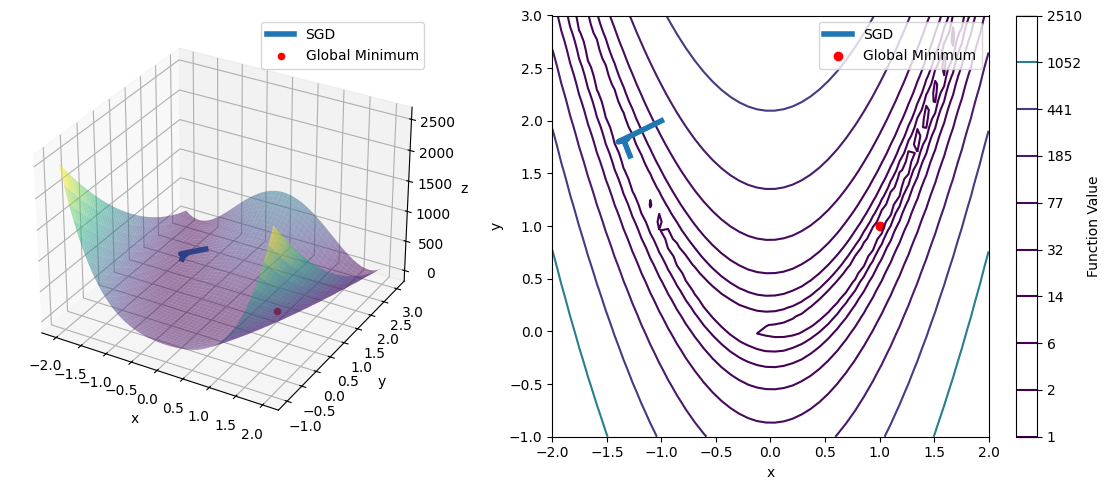

In [4]:
parameters = t.tensor([-1.0, 2.0], requires_grad=True)

N_steps = 100
learning_rate = 0.001
optimizer = StocasticGradientDescent(parameters, learning_rate)

trajectories["SGD"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement the training loop and Stochastic Gradient Descent with Momentum optimizer
(2-5 mins)

When we have momentum in our optimizer, we additioally keep track of the "momentum" with wich we are currently moving $m_t$. The update rule for Stochastic Gradient Descent with Momentum is given by:

$$v_{t+1} = \beta \cdot m_t + (1 - \beta) \cdot \nabla_\theta \text{Loss}(\theta_t)$$
$$\theta_{t+1} = \theta_t - \alpha \cdot m_{t+1}$$

where:
- $\beta$ is the momentum parameter, which determines how much of the previous velocity we keep.
- $m_t$ represents the momentum at iteration $t$.



In [5]:
class Momentum:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.velocity = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            self.velocity = self.beta * self.velocity + self.learning_rate * self.parameters.grad
            self.parameters -= self.velocity

    def zero_grad(self):
        self.parameters.grad.zero_()

test_momentum(Momentum)


Momentum test passed


<details>
<summary>Solution Momentum</summary>
        

```python
class Momentum:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.velocity = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            self.velocity = self.beta * self.velocity + (1 - self.beta) * self.parameters.grad
            self.parameters -= self.learning_rate * self.velocity

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>

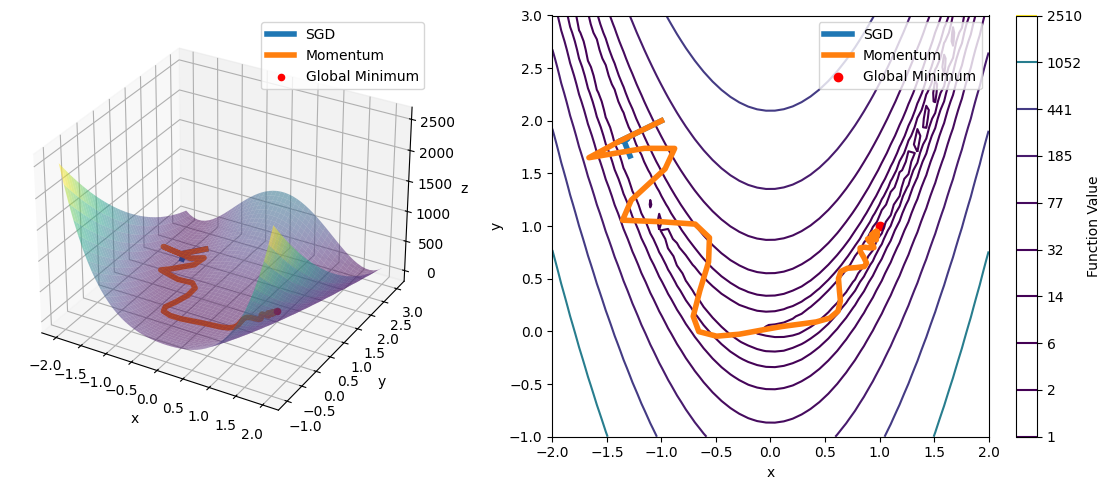

In [6]:

parameters = t.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.001
beta = 0.9
optimizer = Momentum(parameters, learning_rate, beta)
trajectories["Momentum"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement RMSprop optimizer
(2-5 mins)

RMSprop is an optimizer that adapts the learning rate for each parameter. To do that, we keep track of the moving average of the squared gradients $r_t$ and update the parameters as follows:

$$r_{t+1} = \beta \cdot r_t + (1 - \beta) \cdot \nabla_\theta \text{Loss}(\theta_t)^2$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{r_{t+1} + \epsilon}} \cdot \nabla_\theta \text{Loss}(\theta_t)$$

where:
- $\beta$ is the momentum parameter, which determines how much of the previous squared gradients we keep.
- $r_t$ represents the moving average of the squared gradients at iteration $t$.
- $\epsilon$ is a small value added to the denominator to avoid division by zero.


In [7]:
class RMSProp:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.average_squared_grad = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            self.average_squared_grad = self.beta * self.average_squared_grad + (1 - self.beta) * self.parameters.grad ** 2
            self.parameters -= self.learning_rate * self.parameters.grad / (t.sqrt(self.average_squared_grad) + self.epsilon)

    def zero_grad(self):
        self.parameters.grad.zero_()


test_RMSprop(RMSProp)

RMSprop test passed


<details>
<summary>Solution RMSprop</summary>
        

```python
class RMSprop:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.squared_gradients = t.zeros_like(parameters)

    def step(self):
        with t.no_grad():
            self.squared_gradients = self.beta * self.squared_gradients + (1 - self.beta) * self.parameters.grad ** 2
            self.parameters -= self.learning_rate / t.sqrt(self.squared_gradients + self.epsilon) * self.parameters.grad

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>

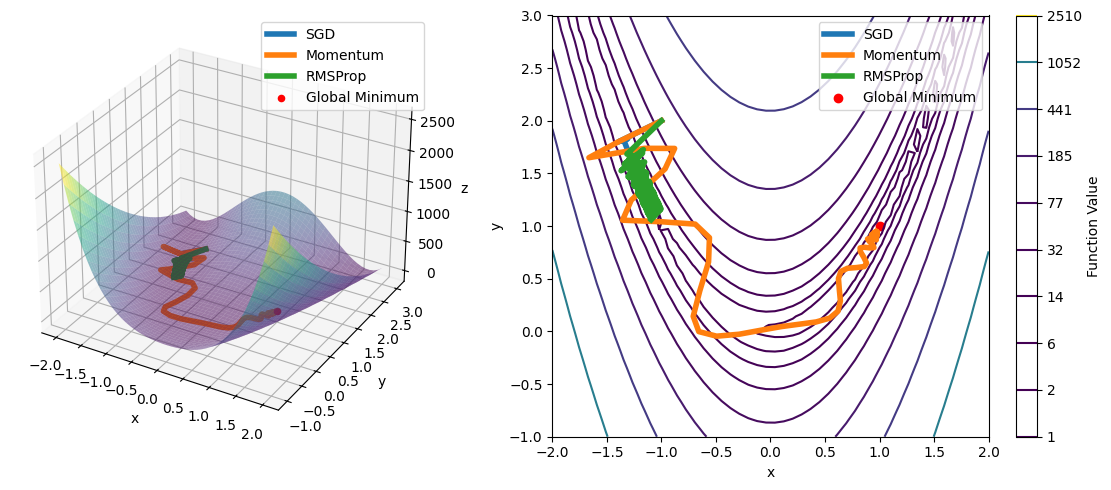

In [8]:
parameters = t.tensor([-1.0, 2.0], requires_grad=True)
N_steps = 100
learning_rate = 0.1
beta = 0.9
epsilon = 1e-8
optimizer = RMSProp(parameters, learning_rate, beta, epsilon)
trajectories["RMSProp"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)

plot_rosenbrock(trajectories)
plt.show()

### Exercise - Implement Adam optimizer
(2-5 mins)

For the Adam optimizer, we now bring both momentum and RMSprop together. We keep track of the moving average of the gradients $m_t$ and the moving average of the squared gradients $r_t$ and update the parameters as follows:

$$m_{t+1} = \beta_1 \cdot m_t + (1 - \beta_1) \cdot \nabla_\theta \text{Loss}(\theta_t)$$
$$r_{t+1} = \beta_2 \cdot r_t + (1 - \beta_2) \cdot \nabla_\theta \text{Loss}(\theta_t)^2$$
$$\hat{m}_{t+1} = \frac{m_{t+1}}{1 - \beta_1^{t+1}}$$
$$\hat{r}_{t+1} = \frac{r_{t+1}}{1 - \beta_2^{t+1}}$$

$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{r}_{t+1} + \epsilon}} \cdot \hat{m}_{t+1}$$

where:
- $\beta_1$ and $\beta_2$ are the momentum parameters for the gradients and squared gradients, respectively.
- $m_t$ and $r_t$ represent the moving averages of the gradients and squared gradients at iteration $t$.
- $\hat{m}_{t+1}$ and $\hat{r}_{t+1}$ are the bias-corrected moving averages.
- $\epsilon$ is a small value added to the denominator to avoid division by zero.


In [9]:
class Adam:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta1: float, beta2: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = t.zeros_like(parameters)
        self.v = t.zeros_like(parameters)
        self.t = 0

    def step(self):
        with t.no_grad():
            self.t += 1
            self.m = self.beta1 * self.m + (1 - self.beta1) * self.parameters.grad
            self.v = self.beta2 * self.v + (1 - self.beta2) * self.parameters.grad ** 2
            m_hat = self.m / (1 - self.beta1 ** self.t)
            v_hat = self.v / (1 - self.beta2 ** self.t)
            self.parameters -= self.learning_rate * m_hat / (t.sqrt(v_hat) + self.epsilon)

    def zero_grad(self):
        self.parameters.grad.zero_()

test_Adam(Adam)


Adam test passed


<details>
<summary>Solution Adam</summary>
        

```python
class Adam:
    def __init__(self, parameters: t.Tensor, learning_rate: float, beta1: float, beta2: float, epsilon: float):
        self.parameters = parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = t.zeros_like(parameters)
        self.v = t.zeros_like(parameters)
        self.t = 0

    def step(self):
        self.t += 1
        with t.no_grad():
            self.m = self.beta1 * self.m + (1 - self.beta1) * self.parameters.grad
            self.v = self.beta2 * self.v + (1 - self.beta2) * self.parameters.grad ** 2
            m_hat = self.m / (1 - self.beta1 ** self.t)
            v_hat = self.v / (1 - self.beta2 ** self.t)
            self.parameters -= self.learning_rate / (t.sqrt(v_hat) + self.epsilon) * m_hat

    def zero_grad(self):
        self.parameters.grad.zero_()
```

</details>


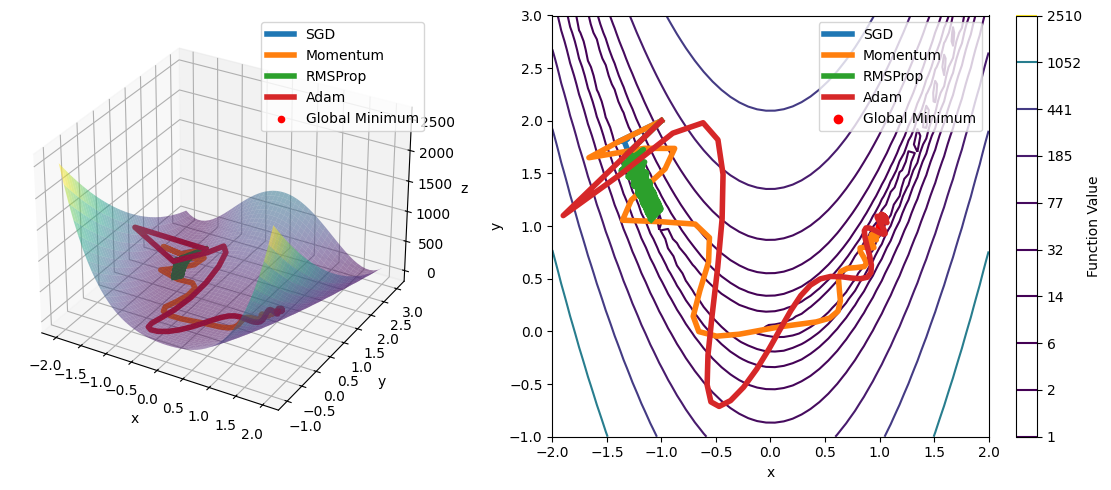

In [11]:

parameters = t.tensor([-1.0, 2.0], requires_grad=True)

N_steps = 100
learning_rate = 0.9
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
optimizer = Adam(parameters, learning_rate, beta1, beta2, epsilon)

trajectories["Adam"] = optimize_function(rosenbrocks_banana, parameters, optimizer, N_steps)
plot_rosenbrock(trajectories)
plt.show()

### BONUS Exercise - Play around with the hyperparameters

Play around with learning rates, the betas and epsilon.

Challange until time is up: get within a 1e-2 range of the minimum of the banana function in as few steps as possible.